In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Wavmat import Wavmat 
from scipy import signal

from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import pearsonr, norm, t

#### Method 1:

$ Y_t = 0.5X_{t-1} + 0.5Y_{t-1} + \epsilon_t $

In [2]:
# x
np.random.seed(99)

n = 512
phi = 0.5

X = np.zeros(n)
Y = np.zeros(n)

for t in range(1,n):
    X[t] = X[t-1]*phi + np.random.standard_normal()
    Y[t] = X[t-1]*phi + Y[t-1]*phi + np.random.standard_normal()

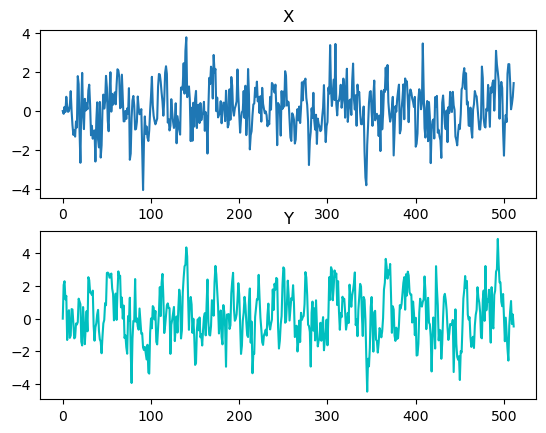

In [3]:
plt.figure()
plt.subplot(2,1,1).set_title('X')
plt.plot(X)

plt.subplot(2,1,2).set_title('Y')
plt.plot(Y, 'c')

# plt.savefig('AR1.png')

In [4]:
# Wavelet Decomposition

# arrays should be nx1
X = np.transpose(np.matrix(X))
Y = np.transpose(np.matrix(Y))

#use default Haar wavelet
W = Wavmat(n, None, 6) 

#WT of data by 'hfilt' @ 6 levels of detail
wd_X = W * X
wd_Y = W * Y

In [5]:
wd_X.shape

(512, 1)

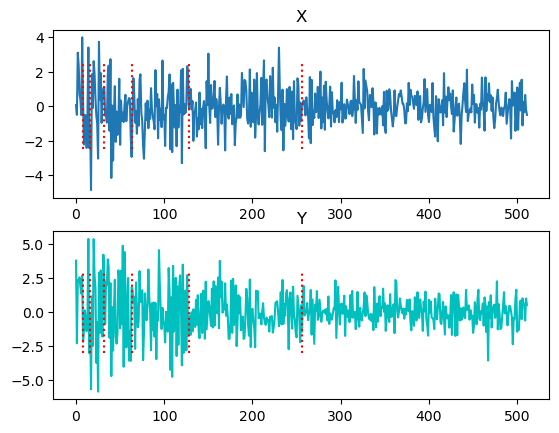

In [6]:
decomps = [8, 16, 32, 64, 128, 256]

plt.figure()
plt.subplot(2,1,1).set_title('X')
plt.plot(wd_X)
for i in decomps:
    plt.vlines(x=i, ymin=-2.5, ymax=2.5, colors='red', ls=':')

plt.subplot(2,1,2).set_title('Y')
plt.plot(wd_Y, 'c')
for i in decomps:
    plt.vlines(x=i, ymin=-3, ymax=3, colors='red', ls=':')
    
# plt.savefig('AR1_WD.png')

In [7]:
Xc = np.array(X).reshape((1,512))
Yc = np.array(Y).reshape((1,512))

corr = np.corrcoef(Xc, Yc)
corr

array([[1.        , 0.31266814],
       [0.31266814, 1.        ]])

In [8]:
dyadic = [8, 16, 32, 64, 128, 256, 512]

X_decomps = {}
for i in range(len(dyadic)-1):
    X_decomps[f'X_l{i+1}'] = np.squeeze(np.array(wd_X[dyadic[i]:dyadic[i+1]]))

Y_decomps = {}
for i in range(len(dyadic)-1):
    Y_decomps[f'Y_l{i+1}'] = np.squeeze(np.array(wd_Y[dyadic[i]:dyadic[i+1]]))
    
Xlist = list(X_decomps.keys())
Ylist = list(Y_decomps.keys())

In [9]:
corrs = []

for i in range(len(Xlist)):
    corrs.append(np.corrcoef(X_decomps[Xlist[i]], Y_decomps[Ylist[i]])[0,1])

corrs

[0.8658467972832917,
 0.8379107404809433,
 0.5776422651740085,
 0.5082178716345019,
 -0.0031488405384992387,
 -0.08657416156047809]

In [10]:
test = pearsonr(X_decomps['X_l1'], Y_decomps['Y_l1'])
ul = test.confidence_interval()

compCIs = []

for i in range(len(Xlist)):
    compCIs.append(pearsonr(X_decomps[Xlist[i]], Y_decomps[Ylist[i]]).confidence_interval())

# compCIs
# matches below

In [8]:
# hand-written
def CI(n,r,a):
    w = 0.5*np.log((1+r)/(1-r))
    z = norm.ppf(1-(a/2))
    wL = w-(z/np.sqrt(n-3))
    wU = w+(z/np.sqrt(n-3))
    rCI = np.zeros(2)
    rCI[0] = (np.exp(2*wL)-1)/(np.exp(2*wL)+1)
    rCI[1] = (np.exp(2*wU)-1)/(np.exp(2*wU)+1)
    return rCI

# call CI for all levels
CIs = np.empty((6,2))
for i in range(6):
    CIs[i] = CI(dyadic[i],corrs[i],0.05)
    
CIs

array([[ 0.47973744,  0.97911505],
       [ 0.68052704,  0.95769323],
       [ 0.57871818,  0.88282844],
       [ 0.18667121,  0.59848369],
       [-0.04334669,  0.29791973],
       [-0.3806201 , -0.15312688]])

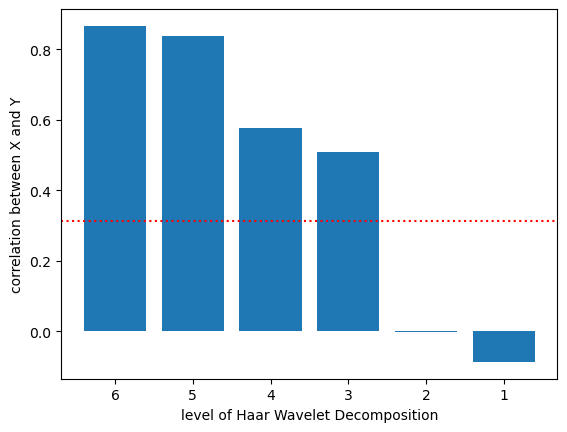

In [12]:
# plot correlation coefficients based on WD level
plt.figure()
plt.bar(range(1,7), corrs)
plt.xlabel('level of Haar Wavelet Decomposition')
plt.ylabel('correlation between X and Y')
plt.xticks(range(1,7), [6,5,4,3,2,1])
plt.axhline(corr[0,1], color='r', ls=':', label='overall correlation')
plt.show()

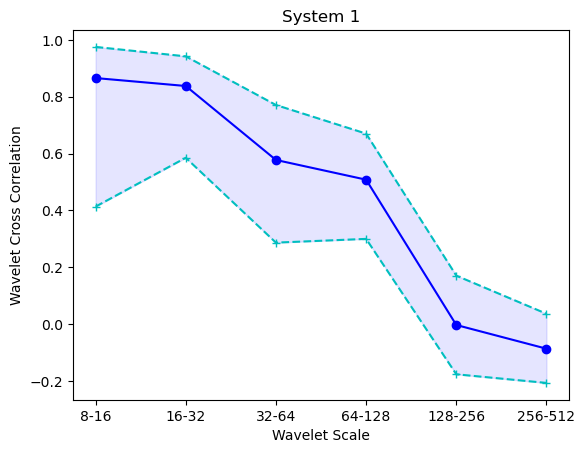

In [35]:
# plot correlation coefficients with 95% CI
lows = CIs[:, 0]
highs = CIs[:, 1]

fig, ax = plt.subplots()
ax.plot(range(1,7), corrs, 'bo-')
ax.plot(range(1,7), lows, 'c+--')
ax.plot(range(1,7), highs, 'c+--')
ax.fill_between(range(1,7), lows, highs, color='b', alpha=.1)
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(['8-16', '16-32', '32-64', '64-128', '128-256', '256-512'])
ax.set_xlabel('Wavelet Scale')
ax.set_ylabel('Wavelet Cross Correlation')
ax.set_title('System 1')

plt.savefig('AR1_WCC.png')

#### Method 2: 

$ Y_t = X_{t-1} + 0.5Y_{t-1} + \epsilon_t $

In [2]:
# x
n = 512
phi = 0.5

X = np.zeros(n)
Y = np.zeros(n)

for t in range(1,n):
    X[t] = X[t-1]*phi + np.random.standard_normal()
    Y[t] = X[t-1] + Y[t-1]*phi + np.random.standard_normal()

In [22]:
# arrays should be nx1
X = np.transpose(np.matrix(X))
Y = np.transpose(np.matrix(Y))

#use default Haar wavelet
W = Wavmat(n, None, 6) 

#WT of data by 'hfilt' @ 6 levels of detail
wd_X = W * X
wd_Y = W * Y

In [23]:
Xc = np.array(X).reshape((1,512))
Yc = np.array(Y).reshape((1,512))

corr = np.corrcoef(Xc, Yc)
corr

array([[1.        , 0.39593307],
       [0.39593307, 1.        ]])

In [24]:
dyadic = [8, 16, 32, 64, 128, 256, 512]

X_decomps = {}
for i in range(len(dyadic)-1):
    X_decomps[f'X_l{i+1}'] = np.squeeze(np.array(wd_X[dyadic[i]:dyadic[i+1]]))

Y_decomps = {}
for i in range(len(dyadic)-1):
    Y_decomps[f'Y_l{i+1}'] = np.squeeze(np.array(wd_Y[dyadic[i]:dyadic[i+1]]))
    
Xlist = list(X_decomps.keys())
Ylist = list(Y_decomps.keys())

In [25]:
corrs = []

for i in range(len(Xlist)):
    corrs.append(np.corrcoef(X_decomps[Xlist[i]], Y_decomps[Ylist[i]])[0,1])

corrs

[0.8851711813164582,
 0.8795307062118995,
 0.7716887963800662,
 0.4135065286469678,
 0.13117048669987497,
 -0.2706478248658435]

In [26]:
# call CI for all levels
CI2 = np.empty((6,2))
for i in range(6):
    CI2[i] = CI(dyadic[i],corrs[i],0.05)
    
CI2

array([[ 0.47973744,  0.97911505],
       [ 0.68052704,  0.95769323],
       [ 0.57871818,  0.88282844],
       [ 0.18667121,  0.59848369],
       [-0.04334669,  0.29791973],
       [-0.3806201 , -0.15312688]])

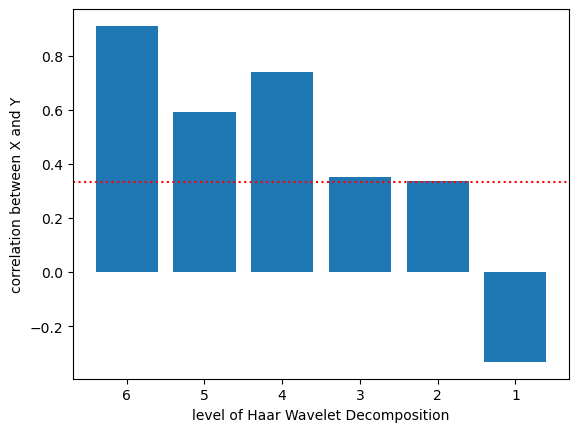

In [42]:
# plot correlation coefficients based on WD level
plt.figure()
plt.bar(range(1,7), corrs)
plt.xlabel('level of Haar Wavelet Decomposition')
plt.ylabel('correlation between X and Y')
plt.xticks(range(1,7), [6,5,4,3,2,1])
plt.axhline(corr[0,1], color='r', ls=':', label='overall correlation')
plt.show()

Text(0.5, 1.0, 'System 2')

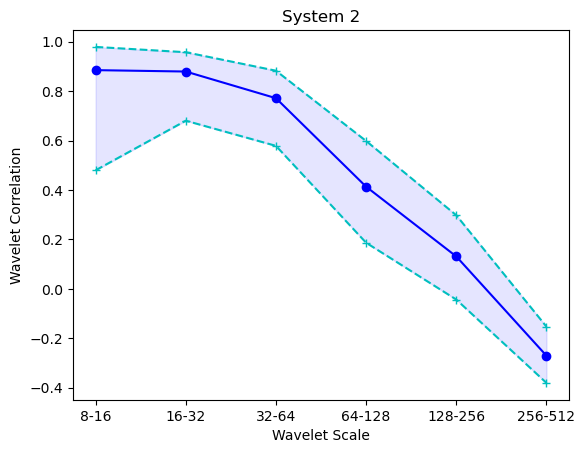

In [27]:
# confidence intervals 
lows = CI2[:, 0]
highs = CI2[:, 1]

fig, ax = plt.subplots()
ax.plot(range(1,7), corrs, 'bo-')
ax.plot(range(1,7), lows, 'c+--')
ax.plot(range(1,7), highs, 'c+--')
ax.fill_between(range(1,7), lows, highs, color='b', alpha=.1)
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(['8-16', '16-32', '32-64', '64-128', '128-256', '256-512'])
ax.set_xlabel('Wavelet Scale')
ax.set_ylabel('Wavelet Correlation')
ax.set_title('System 2')

#plt.savefig('AR1_WCC_2.png')

### Rejection Regions for Correlation 

We have already calcualted the correlation coefficient $r_{XY}$; to test the hypothesis that $\rho = 0$, we calculate the $t$ statistic and use its distribution to get the $\alpha$-level rejection region. We can then plot this rejection region over the bar plot of the correlation coefficients to visualize statistical significance.

In [41]:
import scipy.stats as st

t_stat = []
t_crit = []
alpha = 0.05
q = 1-(alpha/2)

n = 512
l = 6

for i in range(len(corrs)):
    df = n/(2**(l-i))-2
    t = corrs[i]*np.sqrt((df)/(1-corrs[i]**2))
    t_value = st.t.ppf(q, df)
    #t_crit.append((-t_value, t_value))
    t_crit.append(t_value)
    t_stat.append(t)
    
table = pd.DataFrame(corrs, columns=['corrs'])
table['t_stat'] = t_stat
table['critical_values'] = t_crit

In [42]:
table

,corrs,t_stat,critical_values
0,0.865847,4.239144,2.446912
1,0.837911,5.744106,2.144787
2,0.577642,3.875923,2.042272
3,0.508218,4.646515,1.998972
4,-0.003149,-0.035346,1.978971
5,-0.086574,-1.384965,1.969348


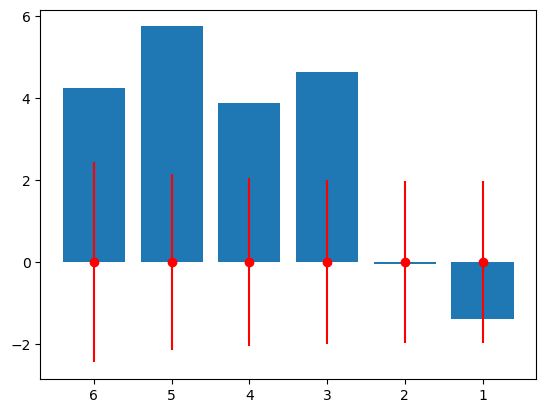

In [43]:
plt.bar(range(1,7), table['t_stat'])
plt.xticks(range(1,7), [6,5,4,3,2,1]) 

c = np.zeros(6)

plt.errorbar(range(1,7), c, yerr=table['critical_values'], fmt="o", color="r")
 
plt.show()

### Comparison of Wavelet Bases

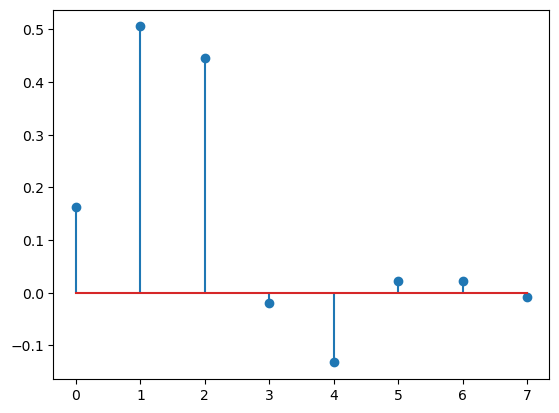

In [11]:
daubfilt = np.array([0.1629, 0.5055, 0.4461, -0.0198, -0.1323, 0.0218, 0.0233, -0.0075]) 
plt.stem(daubfilt)
plt.show()

In [16]:
#use default Haar wavelet
W = Wavmat(n, daubfilt, 6) 

#WT of data by 'hfilt' @ 6 levels of detail
wd_X = W * X
wd_Y = W * Y

dyadic = [8, 16, 32, 64, 128, 256, 512]

X_decomps = {}
for i in range(len(dyadic)-1):
    X_decomps[f'X_l{i+1}'] = np.squeeze(np.array(wd_X[dyadic[i]:dyadic[i+1]]))

Y_decomps = {}
for i in range(len(dyadic)-1):
    Y_decomps[f'Y_l{i+1}'] = np.squeeze(np.array(wd_Y[dyadic[i]:dyadic[i+1]]))
    
Xlist = list(X_decomps.keys())
Ylist = list(Y_decomps.keys())

In [17]:
corrs_db = []

for i in range(len(Xlist)):
    corrs_db.append(np.corrcoef(X_decomps[Xlist[i]], Y_decomps[Ylist[i]])[0,1])

corrs_db

[0.901350937985471,
 0.9017131964871857,
 0.7303438253178717,
 0.552732735907879,
 8.714812426442227e-05,
 -0.42381893890191286]

In [19]:
# call CI for all levels
CI_db = np.empty((6,2))
for i in range(6):
    CI_db[i] = CI(dyadic[i],corrs_db[i],0.05)
    
CI_db

array([[ 0.53907663,  0.98218292],
       [ 0.73417025,  0.96574564],
       [ 0.51205246,  0.86001962],
       [ 0.35518074,  0.70302433],
       [-0.17344599,  0.17361503],
       [-0.51943077, -0.31772634]])

Text(0.5, 1.0, 'System 2')

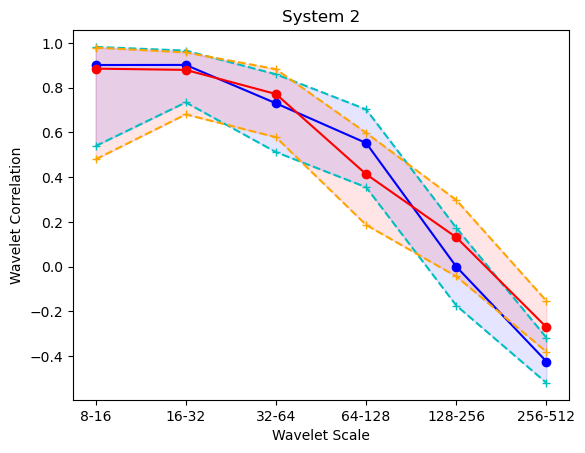

In [31]:
# confidence intervals 
lows_db = CI_db[:, 0]
highs_db = CI_db[:, 1]

fig, ax = plt.subplots()
# Daubechies
ax.plot(range(1,7), corrs_db, 'bo-')
ax.plot(range(1,7), lows_db, 'c+--')
ax.plot(range(1,7), highs_db, 'c+--')
ax.fill_between(range(1,7), lows_db, highs_db, color='b', alpha=.1)

# Haar
ax.plot(range(1,7), corrs, 'ro-')
ax.plot(range(1,7), lows, '+--', color='orange')
ax.plot(range(1,7), highs, '+--', color='orange')
ax.fill_between(range(1,7), lows, highs, color='r', alpha=.1)

ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(['8-16', '16-32', '32-64', '64-128', '128-256', '256-512'])
ax.set_xlabel('Wavelet Scale')
ax.set_ylabel('Wavelet Correlation')
ax.set_title('System 2')

### Extra  

from the theory we have that  

$$
w_x^j = \frac{\lVert d_x^j \rVert_2^2}{\lVert d_x \rVert_2^2} 
$$

where $ d_x^j $ is the $ 2^{J-l} \times 1 $ vector of detail coefficients at level $ J-l $ and $ d_x $ is the $ 2^J \times 1 $ vector of all coefficients from the DWT of signal $ X $. $ w_x^j $ then forms the weight on the correlation $ \hat{\rho}_{X,Y}^j $ when we decompose the entire correlation of the 2 signals into a weighted sum of the level-wise correlations.

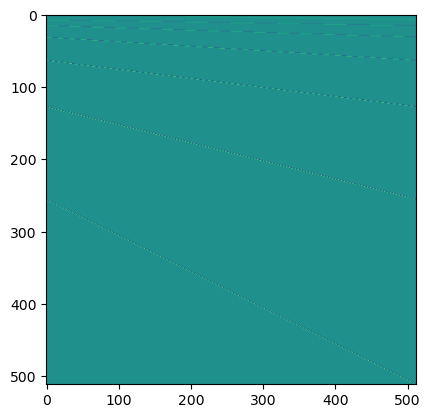

In [9]:
# level-6 Haar DWT
# W seems to be just the wavelet coefficents, no scaling signals?
plt.imshow(W, cmap='viridis')

In [19]:
dlist = [0, 8, 16, 32, 64, 128, 256]
for i in dlist:
    print(round(W[i,0], 3))
    
# 1/rt(2)    = 0.707
# 1/2        = 0.5
# 1/2rt(2)   = 0.354
# 1/4        = 0.25
# 1/4rt(2)   = 0.177
# 1/8        = 0.125

0.125
0.125
0.177
0.25
0.354
0.5
0.707


In [27]:
# sum(1 for element in W[1,:] if element != 0) = 64
dr = [8, 16, 32, 64, 128, 256]

hd = {}

for i in dr:
    Wtemp = W[i, :]
    j = 6-dr.index(i)
    hd["wavelet_l{0}".format(j)] = Wtemp[Wtemp != 0]

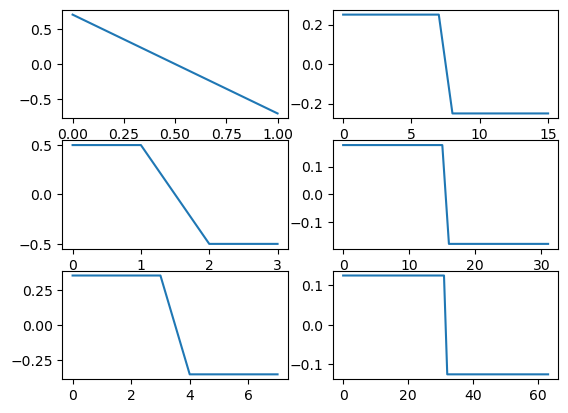

In [36]:
fig, axs = plt.subplots(3, 2)
axs[0, 0].plot([0,1], hd['wavelet_l1'])

axs[1, 0].plot(hd['wavelet_l2'])

axs[2, 0].plot(hd['wavelet_l3'])

axs[0, 1].plot(hd['wavelet_l4'])

axs[1, 1].plot(hd['wavelet_l5'])

axs[2, 1].plot(hd['wavelet_l6'])